<a href="https://colab.research.google.com/github/bioai96/Pytorch/blob/main/Mol2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝 Chemical Data 에 적용하기

## Mol2vec

https://github.com/samoturk/mol2vec
Mol2vec - an unsupervised machine learning approach to learn vector representations of molecular substructures

word2vec에서 착안 함
의미론적인 부분이 학습이 가능 



### 1. Github 라이브러리 설치하기

In [1]:
pip install git+https://github.com/samoturk/mol2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-ctyi7i4k
  Running command git clone -q https://github.com/samoturk/mol2vec /tmp/pip-req-build-ctyi7i4k
     |████████████████████████████████| 1.6 MB 2.1 MB/s 
  Created wheel for mol2vec: filename=mol2vec-0.1-py3-none-any.whl size=14038 sha256=49d25a0fbfefbfb9d2497ca137ef1bfadf2a795178350afab410644670ae8a9d
  Stored in directory: /tmp/pip-ephem-wheel-cache-359g2jds/wheels/80/d5/e1/90dc211e4a17780f99eaec43328470a70284cd731ef2a77034
Successfully built mol2vec


### 2. Dependency 라이브러리 설치하기

In [2]:
!pip3 install gensim==3.8.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.2 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 19 kB/s 


### 3. 데이터 준비하기

In [4]:
!wget https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/molnet_publish/bbbp.zip
!ls
!unzip bbbp.zip

--2022-09-28 06:18:14--  https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/molnet_publish/bbbp.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.112
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46174 (45K) [application/zip]
Saving to: ‘bbbp.zip’

bbbp.zip            100%[===================>]  45.09K  --.-KB/s    in 0.1s    

2022-09-28 06:18:14 (315 KB/s) - ‘bbbp.zip’ saved [46174/46174]

bbbp.zip  sample_data
Archive:  bbbp.zip
  inflating: BBBP.csv                
  inflating: BBBP_README             


In [5]:
import pandas as pd

data = pd.read_csv('BBBP.csv')


In [6]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np

In [7]:
idxs=[]
for i, smiles in enumerate(data["smiles"]):
    mol = Chem.MolFromSmiles(smiles)
    if (mol==None):
      idxs.append(i)
data=data.drop(idxs, axis=0)

In [8]:
data['smiles'][0]

'[Cl].CC(C)NCC(O)COc1cccc2ccccc12'

In [9]:
#word2vec모델을 사용하기 위해 gensim.models의 word2vec import
from gensim.models import word2vec
#mol2vec에 필요한 라이브러리와 함수들을 import
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec,featurize
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg

In [10]:
aas = [Chem.MolFromSmiles(x) for x in data["smiles"]]

In [11]:
#mol2alt_sentence를 사용하여 문장으로 변환 문장 변환에는 identifier들이 생성됨
sentence=mol2alt_sentence(aas[0],1)
len(sentence), sentence

(39,
 ['3855290507',
  '2246728737',
  '3537119515',
  '2245273601',
  '2635303940',
  '2246728737',
  '3537119515',
  '847961216',
  '1369588494',
  '2245384272',
  '781912670',
  '2245273601',
  '1674219510',
  '864662311',
  '1542633699',
  '2245384272',
  '4003049590',
  '864674487',
  '2115476908',
  '3217380708',
  '1135286194',
  '3218693969',
  '951226070',
  '3218693969',
  '98513984',
  '3218693969',
  '951226070',
  '3217380708',
  '2360741695',
  '3218693969',
  '951226070',
  '3218693969',
  '98513984',
  '3218693969',
  '98513984',
  '3218693969',
  '951226070',
  '3217380708',
  '3983062349'])

In [12]:
it = IdentifierTable(sentence, [aas[0]]*len(sentence), [sentence]*len(sentence), 5, 1)
it

### 4. mol2vec 사용하기 위해 학습된 결과 가져오기

In [13]:
#이미 대량의 Chemical Library(ZINCv15, ChEMBLv23)로 학습한 모델 결과 다운로드
!wget https://raw.githubusercontent.com/samoturk/mol2vec/master/examples/models/model_300dim.pkl

--2022-09-28 06:18:43--  https://raw.githubusercontent.com/samoturk/mol2vec/master/examples/models/model_300dim.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76786055 (73M) [application/octet-stream]
Saving to: ‘model_300dim.pkl’

model_300dim.pkl    100%[===================>]  73.23M  96.2MB/s    in 0.8s    

2022-09-28 06:18:49 (96.2 MB/s) - ‘model_300dim.pkl’ saved [76786055/76786055]



In [14]:
#wor2vec model에 이미 학습되었던 가중치 값을 불러옴
w2vmodel = word2vec.Word2Vec.load('model_300dim.pkl')

In [15]:
len(w2vmodel.wv.vocab.keys())

21003

In [16]:
data.head(n=1)

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12


### w2v생성을 위한 3단계 변환 과정
* 1. data에 Mol object 만들어주기
* 2. Mol object를 sentence로 변환하기(MolSentence 객체로 반환)
* 3. sentence를 vec로 변환하기 (Dfvec 객체로 반환)

,smiles,Molecule
0,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,

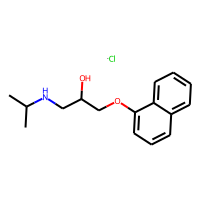

In [17]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
PandasTools.AddMoleculeColumnToFrame(data,'smiles','Molecule')
data[["smiles","Molecule"]].head(1)

In [18]:
data['sentence'] = data.apply(lambda x: MolSentence(mol2alt_sentence(x['Molecule'], 1)), axis=1)

In [19]:
data['mol2vec'] = [DfVec(x) for x in sentences2vec(data['sentence'], w2vmodel, unseen='UNK')]

In [20]:
data['mol2vec']= [x.vec for x in data['mol2vec']]

,num,name,p_np,smiles,Molecule,sentence,mol2vec
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,,"(3855290507, 2246728737, 3537119515, 224527360...","[-0.32573423, -2.188017, -2.0390112, 5.854848,..."
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,,"(2246699815, 4194366826, 864942730, 1510328189...","[0.36889017, -1.9671557, -0.88539, -0.20521241..."
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,,"(3217380708, 3796970912, 3217380708, 369315086...","[5.26491, -5.150363, -4.037241, 4.560603, -2.0..."
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,,"(2968968094, 2142032900, 2968968094, 214203290...","[0.5659893, -4.693765, -0.76939243, 4.186935, ..."
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,,"(2246728737, 422715066, 3217380708, 3662562115...","[0.5433947, -5.267678, -2.3712387, 1.1504936, ..."
...,...,...,...,...,...,...,...
2045,2049,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl,,"(3218693969, 994485099, 3217380708, 2424973678...","[2.7910373, -1.611804, -3.819929, 4.2662992, -..."
2046,2050,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...,,"(2976033787, 3109000344, 2092489639, 934550081...","[4.230009, -5.7500186, -6.662907, 4.150695, 1...."
2047,2051,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...,,"(3189554341, 3772526016, 2041434490, 247958282...","[0.41964823, -2.1095579, -2.2520032, 6.2380543..."
2048,2052,tofisoline,1,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...,,"(3218693969, 994485099, 3217380708, 1135286194...","[0.48838872, -2.5749228, -4.676146, 9.106438, ..."

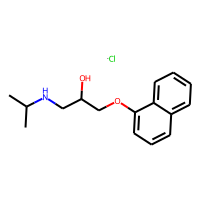
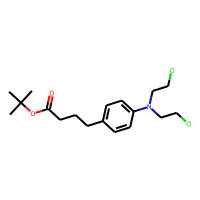
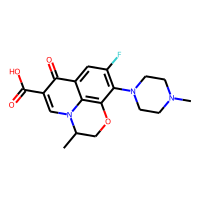
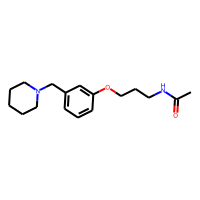
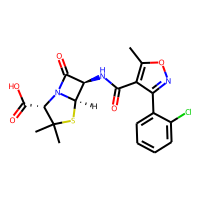
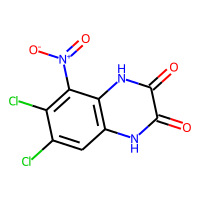
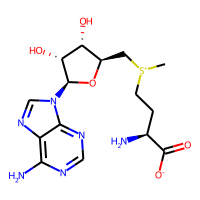
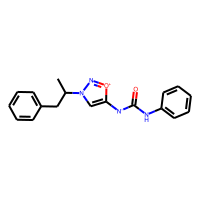
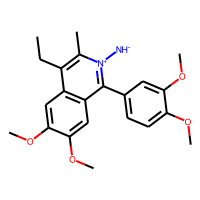
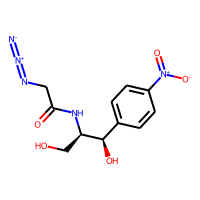

In [21]:
data

### 5. 훈련 데이터, 테스트 데이터 분할하기

In [22]:
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(data, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.1/0.9, random_state=42)

datasets = {
    "train": train,
    "val":  val,
    "test": test
}

datasets

{'train':        num                       name  p_np  \
 555    557                    cocaine     1   
 877    879                 moxalactam     0   
 1568  1572                sumacetamol     1   
 511    513                 GR89696_et     1   
 1644  1648   tryptophan(l-tryptophan)     1   
 ...    ...                        ...   ...   
 1208  1212  etiracetam(levetiracetam)     1   
 637    639                 glaziovine     1   
 1505  1509                propyperone     1   
 832    834               fenoxazoline     0   
 1868  1872                  indalpine     1   
 
                                                  smiles  \
 555        COC(=O)[C@H]1[C@H](CC2CCC1N2C)OC(=O)c3ccccc3   
 877   CO[C@]1(NC(=O)C(C(O)=O)c2ccc(O)cc2)[C@H]3OCC(=...   
 1568     [C@H](C(=O)OC1=CC=C(C=C1)NC(=O)C)(NC(=O)C)CCSC   
 511   c1(ccc(c(c1)Cl)Cl)CC(N1[C@H](CN(CC1)C(=O)OCC)C...   
 1644               N[C@@H](CC1=C[NH]C2=CC=CC=C12)C(=O)O   
 ...                                                 

### 6. 커스텀 데이터 세트 만들기

In [23]:
from torch.utils.data import Dataset

class bbbpDataset(Dataset):
    def __init__(self,df):
        self.x = list(df["mol2vec"])
        self.y = list(df["p_np"].values)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return torch.tensor(self.x[index]).float(), torch.tensor(self.y[index]).float()
    

bbbpdata = {
    "train" : bbbpDataset(datasets["train"]),
    "val" : bbbpDataset(datasets["val"]),
    "test" : bbbpDataset(datasets["test"])
}

bbbpdata

{'train': <__main__.bbbpDataset at 0x7fdbad750c50>,
 'val': <__main__.bbbpDataset at 0x7fdbad755050>,
 'test': <__main__.bbbpDataset at 0x7fdb40138410>}

In [24]:
import torch
from torch.utils.data import DataLoader

bbbp_dataloaders = {
    "train": DataLoader(bbbpdata["train"], batch_size=32, shuffle=True),
    "val": DataLoader(bbbpdata["val"], batch_size=32, shuffle=False),
    "test": DataLoader(bbbpdata["test"], batch_size=32, shuffle=False)
}

bbbp_dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fdb4006d650>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fdb4006d7d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fdb4006d850>}

In [25]:
for data in bbbp_dataloaders["train"]:
    x, y = data
    print(x.shape, y.shape)

torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([32])
torch.Size([32, 300]) tor

### 7. 모델 만들기

In [26]:
import torch
from torch import nn

# cpu나 gpu에서 모두 동작하게 만들기
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [27]:
class bbbp_MLP(nn.Module):
    def __init__(self):
        super(bbbp_MLP,self).__init__()
        self.linear1 = nn.Linear(300, 512)
        self.linear2 = nn.Linear(512,256)
        self.output = nn.Linear(256,1)
        self.dropout1 = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.output(out)
        return out

model = bbbp_MLP()
model.to(device) 

bbbp_MLP(
  (linear1): Linear(in_features=300, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

### 8. 손실 및 최적화 함수 설정

In [28]:
import torch.optim as optim

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model.parameters(),lr = 0.001)

def acc_fn(y_true, y_pred) :
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### 9. 모델 학습하기

In [29]:
torch.manual_seed(42)

# 전체 학습 데이터로 몇번 학습 시킬 것이냐를 결정
epochs = 101 #반복횟수 늘리기

# 손실 값을 저장하기 위한 변수 정의
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0

    for i, data in enumerate(bbbp_dataloaders["train"]):
        x, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = model(x)
        train_loss = loss_fn(outputs, y.view(-1, 1))
        train_acc = acc_fn(torch.round(torch.sigmoid(outputs)), y.view(-1,1))
        train_loss.backward()
        optimizer.step()
        
        epoch_train_loss += train_loss.item()
        
    model.eval()
    epoch_val_loss = 0.0
    with torch.inference_mode():
        for i, data in enumerate(bbbp_dataloaders["test"]):
            x, y = data[0].to(device), data[1].to(device)
                        
            outputs = model(x)
            val_loss = loss_fn(outputs, y.view(-1, 1))
            val_acc = acc_fn(torch.round(torch.sigmoid(outputs)), y.view(-1,1))
            epoch_val_loss += val_loss.item()
            
    epoch_train_loss /= len(bbbp_dataloaders["train"])
    epoch_val_loss /= len(bbbp_dataloaders["test"])
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    if epoch % 10 == 0:
        print("[Epoch %d] Train Loss: %.3f  Train acc : %.3f Validation Loss: %.3f Validation acc : %.3f" %
              (epoch, epoch_train_loss, train_acc, epoch_val_loss, val_acc))


[Epoch 0] Train Loss: 0.613  Train acc : 58.065 Validation Loss: 0.606 Validation acc : 58.333
[Epoch 10] Train Loss: 0.466  Train acc : 83.871 Validation Loss: 0.447 Validation acc : 100.000
[Epoch 20] Train Loss: 0.432  Train acc : 90.323 Validation Loss: 0.418 Validation acc : 100.000
[Epoch 30] Train Loss: 0.407  Train acc : 80.645 Validation Loss: 0.410 Validation acc : 100.000
[Epoch 40] Train Loss: 0.388  Train acc : 83.871 Validation Loss: 0.405 Validation acc : 100.000
[Epoch 50] Train Loss: 0.383  Train acc : 87.097 Validation Loss: 0.396 Validation acc : 100.000
[Epoch 60] Train Loss: 0.373  Train acc : 100.000 Validation Loss: 0.397 Validation acc : 100.000
[Epoch 70] Train Loss: 0.363  Train acc : 90.323 Validation Loss: 0.386 Validation acc : 100.000
[Epoch 80] Train Loss: 0.367  Train acc : 90.323 Validation Loss: 0.385 Validation acc : 100.000
[Epoch 90] Train Loss: 0.349  Train acc : 87.097 Validation Loss: 0.380 Validation acc : 100.000
[Epoch 100] Train Loss: 0.339  

### 10. 결과 리포팅하기

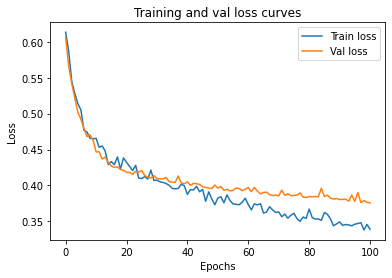

In [30]:
import matplotlib.pyplot as plt

epoch_count = range(epochs)
plt.plot(epoch_count, train_losses, label="Train loss")
plt.plot(epoch_count, val_losses, label="Val loss")
plt.title("Training and val loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

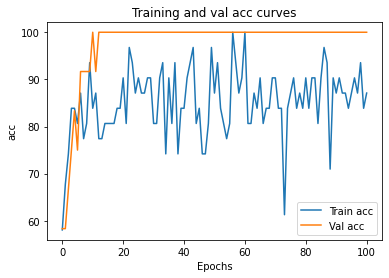

In [31]:
epoch_count = range(epochs)
plt.plot(epoch_count, train_accs, label="Train acc")
plt.plot(epoch_count, val_accs, label="Val acc")
plt.title("Training and val acc curves")
plt.ylabel("acc")
plt.xlabel("Epochs")
plt.legend();